In [158]:
#Import necessary packages 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt

In [159]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [160]:
# suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

The  data  is  available  as  two  attached  CSV  files:

`takehome_user_engagement.csv`

`takehome_users.csv`


The  data  has  the  following  two  tables:

 1  A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the
 product  in  the  last  two  years.   This  table  includes:
 
    ● name:  the  user's  name
    ● object_id:   the  user's  id
    ● email:  email  address
    ● creation_source:   how  their  account  was  created.  This  takes  on  oneof  5  values:
        ○ PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace
        ○ GUEST_INVITE:  invited  to  an  organization  as  a  guest(limited  permissions)
        ○ ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
        ○ SIGNUP:  signed  up  via  the  website
        ○ SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their loginid)
    ● creation_time:  when  they  created  their  account
    ● last_session_creation_time:   unix  timestamp  of  last  login
    ● opted_in_to_mailing_list:  whether  they  have  opted  into  receiving  marketing  emails
    ● enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip
    ● org_id:   the  organization  (group  of  users)  they  belong  to
    ● invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).
 2  A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day
that  a  user  logged  into  the  product

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .
We  suggest  spending  1-2  hours  on  this,  but  you're  welcome  to  spend  more  or  less.
Please  send  us  a  brief  writeup  of  your  findings  (the  more  concise,  the  better  ­­  no  more
than  one  page),  along  with  any  summary  tables,  graphs,  code,  or  queries  that  can  help
us  understand  your  approach.  Please  note  any  factors  you  considered  or  investigation
you  did,  even  if  they  did  not  pan  out.  Feel  free  to  identify  any  further  research  or  data
you  think  would  be  valuable

## Data Wrangling

Load the data and take a peek.

In [161]:
## Load data 
df1 = pd.read_csv("takehome_users.csv", encoding_errors='replace')
df2 = pd.read_csv("takehome_user_engagement.csv")

In [162]:
df1.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [163]:
df2.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [164]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [165]:
print("There were {} unique users and {} distinct logins in the user_engagement file"
      .format(df2['user_id'].nunique(), len(df2)))
                                                                                             

There were 8823 unique users and 207917 distinct logins in the user_engagement file


In [166]:
print("This corresponds with the {} nonnull values in last_session_creation_time of the users file".format(len(df1[~df1['last_session_creation_time'].isnull()])))

This corresponds with the 8823 nonnull values in last_session_creation_time of the users file


### Find the adopted users

In [167]:
import datetime

#set the time_stamp to datetime and the set it as the index
df2.time_stamp = pd.to_datetime(df2.time_stamp)
df2 = df2.set_index('time_stamp', drop= True)

In [168]:
from datetime import timedelta

def label_adopted(x):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    df_temp = df2.loc[df2['user_id'] == x] #select out rows of this user
    df_temp = df_temp.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted 


    

In [169]:
#apply to  df1 to label users as adopted=true 
df1['adopted_user'] = df1['object_id'].apply(label_adopted)

In [170]:
print("There are {} adopted users out of the total {} users.".format(df1.adopted_user.sum(),len(df1[~df1['last_session_creation_time'].isnull()])))

There are 1656 adopted users out of the total 8823 users.


In [171]:
df1.set_index('object_id')
df1.index.name = 'user_id'
df1.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
user_id,,,,,,,,,,,
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [172]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


Convert the `creation_time` and `last_session_creation_time` to datetime objects.

In [173]:
df1['creation_time'] = pd.to_datetime(df1['creation_time'])

df1['last_session_creation_time'] = df1['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),na_action='ignore')

df1['last_session_creation_time'] = pd.to_datetime(df1['last_session_creation_time'])                                                                              

In [174]:
#subtract to find time active
df1['activity_length'] = df1['last_session_creation_time'] - df1['creation_time']
#lets settle for seconds instead of days to make the time differences more distinct
df1['activity_length'] = [x.total_seconds() for x in df1['activity_length']]

Find the time between these two times as `activity_length` in seconds.

In [175]:
df1['activity_length'] = df1['last_session_creation_time'] - df1['creation_time']
df1['activity_length'] = [x.total_seconds() for x in df1['activity_length']]
#df1.info()

In [176]:
df1.groupby('adopted_user')['activity_length'].mean()

adopted_user
0    4.368216e+05
1    2.525076e+07
Name: activity_length, dtype: float64

Activity length seems to be much longer for adopted than unadopted users.

Let's also count how many users were invited by a user.

In [177]:
invited_count = df1.groupby('invited_by_user_id')['object_id'].count()
invited_count.name = 'invited_count'

In [178]:
len(invited_count[invited_count > 0])

2564

In [179]:
df1 = df1.merge(invited_count, how='left',left_on='object_id', right_index=True )

In [180]:
df1['invited_count'].fillna(0, inplace=True)

In [181]:
df1.groupby('adopted_user')['invited_count'].mean()

adopted_user
0    0.510731
1    0.684783
Name: invited_count, dtype: float64

This also seems useful.

In [182]:
df1.invited_by_user_id = df1.invited_by_user_id.fillna(0)

In [183]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  adopted_user                12000 non-null  int64         
 11  activity_length             8823 non-null   float64   

## EDA
Let's start with looking at each feature.

First `creation_time` was used to generate the `activity_length` but probably has no further use.

Next, `name` has no real value so this can be dropped.

`email` may have some use so lets look.


In [184]:
emails = df1.email.str.split('@')
df1['domain_name'] = [ x[1] for x in emails]
df1['domain_name'].nunique()

1184

In [185]:
df1.groupby(['domain_name', 'adopted_user']).count().sort_values(by='object_id',ascending=False).head(12)

,,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,activity_length,invited_count
domain_name,adopted_user,,,,,,,,,,,,
gmail.com,0,3005,3005,3005,3005,3005,2373,3005,3005,3005,3005,2373,3005
yahoo.com,0,2180,2180,2180,2180,2180,1459,2180,2180,2180,2180,1459,2180
jourrapide.com,0,1089,1089,1089,1089,1089,713,1089,1089,1089,1089,713,1089
cuvox.de,0,1058,1058,1058,1058,1058,684,1058,1058,1058,1058,684,1058
gustr.com,0,1029,1029,1029,1029,1029,692,1029,1029,1029,1029,692,1029
hotmail.com,0,960,960,960,960,960,598,960,960,960,960,598,960
gmail.com,1,557,557,557,557,557,557,557,557,557,557,557,557
yahoo.com,1,267,267,267,267,267,267,267,267,267,267,267,267
hotmail.com,1,205,205,205,205,205,205,205,205,205,205,205,205


The email domain maybe useful but will require an other category to go with the 6 main domains. See how things go without it but could be an addition for future research.

In [186]:
# Creation source and adopted user
df1.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.170596
ORG_INVITE            0.134932
PERSONAL_PROJECTS     0.081478
SIGNUP                0.144705
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

In [187]:
# check mailing list and marketing drip
df1.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.136243
1    0.143287
Name: adopted_user, dtype: float64

In [188]:
df1.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.137049
1    0.143415
Name: adopted_user, dtype: float64

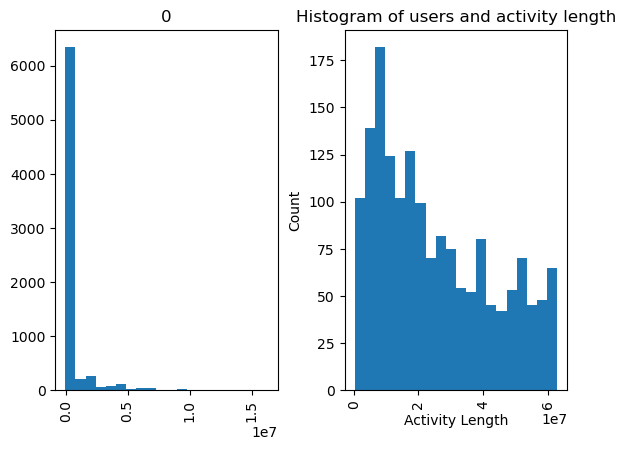

In [189]:
# Histograms
df1['activity_length'].hist(bins=20, by=df1['adopted_user'])
plt.xlabel('Activity Length')
plt.ylabel('Count')
plt.title('Histogram of users and activity length' );

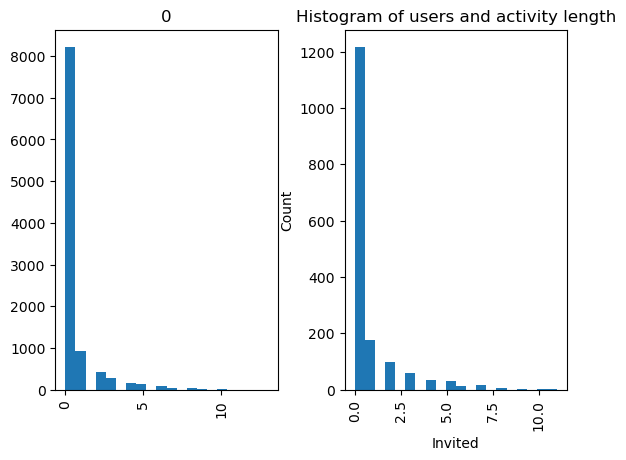

In [190]:
# Histograms
df1['invited_count'].hist(bins=20, by=df1['adopted_user'])
plt.xlabel('Invited')
plt.ylabel('Count')
plt.title('Histogram of users and activity length' );

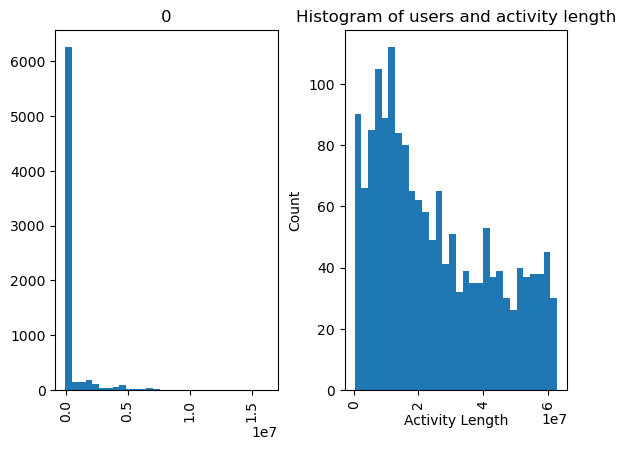

In [191]:
# Histograms
df1['activity_length'].hist(bins=30, by=df1['adopted_user'])
plt.xlabel('Activity Length')
plt.ylabel('Count')
plt.title('Histogram of users and activity length' );

In [192]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  207917 non-null  int64
 1   visited  207917 non-null  int64
dtypes: int64(2)
memory usage: 4.8 MB


<Axes: xlabel='time_stamp'>

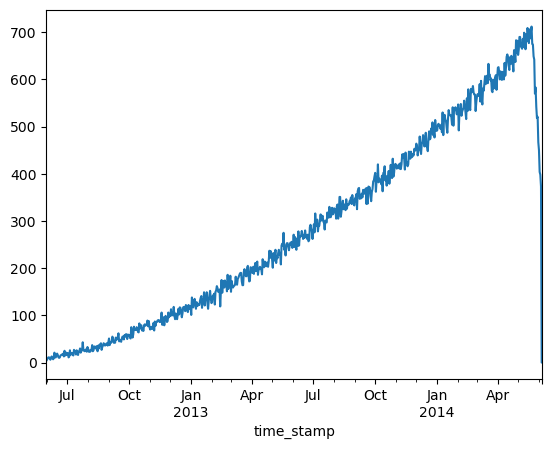

In [193]:
#Group by day and count
df_day = df2.resample('D').sum()
df_day['visited'].plot()

There is a clear upward trend in the number of daily logins with some variance along the way. 

Let's see if there is variability by day of the week.

In [194]:
df_weekly = pd.DataFrame()


for i, row in df_day.iloc[4:,:].iterrows():  # 4 is to skip to first Monday
    day = i.weekday()
    if day == 0:
        index = i
    df_weekly.loc[index, day] = row['visited']
    
df_weekly.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_weekly.dropna(axis=0, inplace=True)

Looking at the pattern by day of the week there does not seem to be much variance here.

<Axes: >

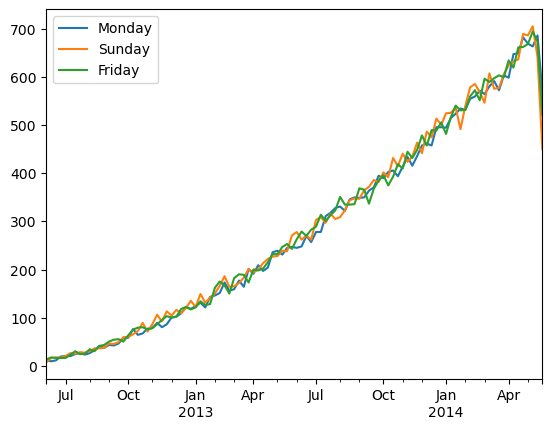

In [195]:
df_weekly[['Monday','Sunday','Friday']].plot() ## used only three days for readabilty

Resample by hour and the upward trend is still clear but the variance is more pronounced. If needed a Chi-squared test could check if the distribution is uniform or a one way ANOVA test could check if the means are likely the same.

<Axes: xlabel='time_stamp'>

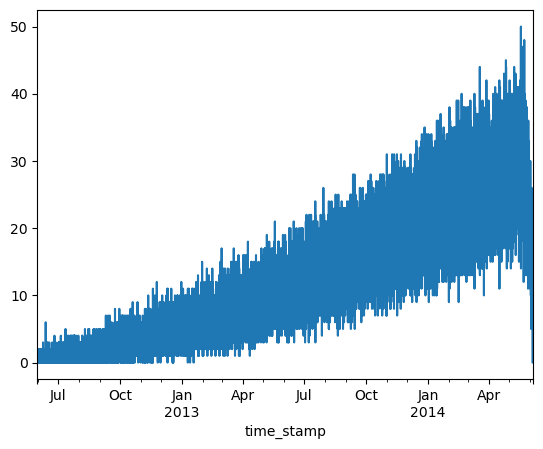

In [196]:
df_hour = df2['visited'].resample('h').sum()
df_hour.plot()

In [197]:
df_by_time  = pd.DataFrame()
df_hour = pd.DataFrame(df_hour)

for i, row in df_hour.iloc[16:,:].iterrows():  # 15 is to skip to first hour 0
    hour = i.hour
    #print(hour)
    if hour == 0:
        index = i
    df_by_time.loc[index, hour] = row['visited']
    
df_by_time.dropna(axis=0, inplace=True)

Look at the total logins by time of day. However, it is not clear that the data was all from the same time zone so the user's local login time may not be known. In fact the timezones could also cause sbetween days as well. 

<Axes: >

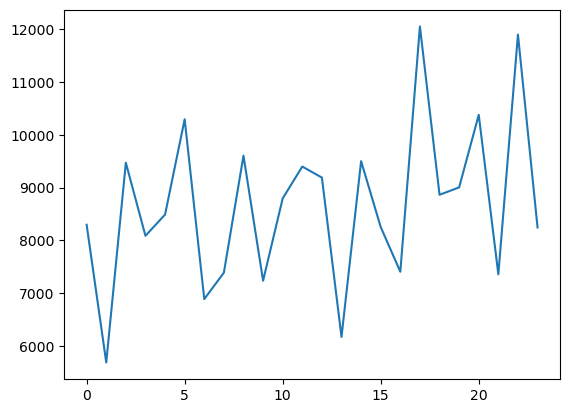

In [198]:
df_by_time.sum().plot()

There seems to be a lull around breakfast time and a higher amount of logins in the late afternoon/evening but again this may not be of any significance due to the local timezones.

In [199]:
df_day = pd.DataFrame(df_day)

In [200]:
df_weekly = pd.DataFrame()


for i, row in df_day.iloc[4:,:].iterrows():  # 4 is to skip to first Monday
    day = i.weekday()
    if day == 0:
        index = i
    df_weekly.loc[index, day] = row['visited']
    
df_weekly.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_weekly.dropna(axis=0, inplace=True)

In [201]:
df_weekly

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
2012-06-04,11.0,10.0,6.0,11.0,13.0,10.0,7.0
2012-06-11,9.0,21.0,11.0,11.0,17.0,19.0,16.0
2012-06-18,11.0,10.0,11.0,15.0,16.0,17.0,17.0
2012-06-25,19.0,13.0,25.0,15.0,16.0,21.0,17.0
2012-07-02,20.0,11.0,13.0,26.0,16.0,20.0,20.0
...,...,...,...,...,...,...,...
2014-04-28,683.0,656.0,682.0,652.0,663.0,690.0,690.0
2014-05-05,670.0,668.0,665.0,686.0,669.0,699.0,687.0
2014-05-12,664.0,696.0,681.0,709.0,695.0,677.0,706.0
2014-05-19,687.0,701.0,712.0,675.0,674.0,649.0,642.0


In [202]:
df_weekly.describe()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,281.798077,282.557692,282.394231,283.115385,285.798077,285.759615,286.182692
std,204.209125,205.404400,204.292120,202.312519,203.993165,203.487911,203.396058
min,9.000000,10.000000,6.000000,11.000000,13.000000,10.000000,7.000000
25%,97.250000,91.500000,101.500000,104.250000,101.500000,99.000000,108.250000
50%,246.000000,257.000000,250.000000,254.500000,258.000000,255.000000,262.000000
75%,441.500000,442.000000,447.250000,452.250000,451.250000,454.250000,444.000000
max,687.000000,701.000000,712.000000,709.000000,695.000000,699.000000,706.000000


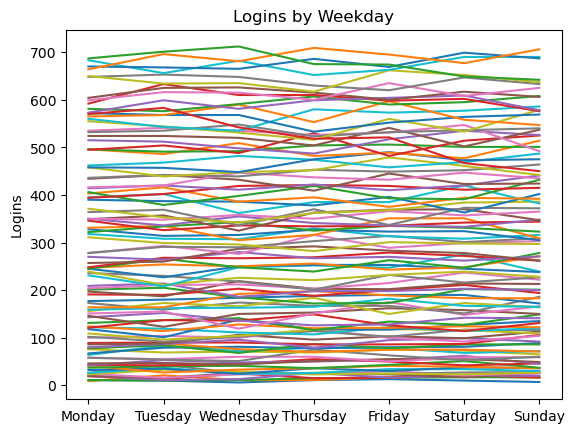

In [203]:
#Plot all weeks
for i, row in df_weekly.iterrows():
    plt.plot(df_weekly.columns, row)

plt.title("Logins by Weekday")
plt.ylabel("Logins")
plt.show()

## Modelling


In [204]:
df = df1.iloc[:,4:]
df = df.drop('last_session_creation_time', axis=1)
df = df.drop('domain_name', axis=1)
df['activity_length'] = df['activity_length'].fillna(0)

Encode the categorical variables.

In [205]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
creation_labels = gle.fit_transform(df1['creation_source'])
df.creation_source = creation_labels

org_id_labels = gle.fit_transform(df1['org_id'])
df.org_id = org_id_labels

invited_labels = gle.fit_transform(df1['invited_by_user_id'])
df.invited_by_user_id = invited_labels

In [206]:
df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,activity_length,invited_count
user_id,,,,,,,,
0,0,1,0,11,2325,0,-21600.0,0.0
1,1,0,0,1,56,1,11728800.0,0.0
2,1,0,0,94,298,0,-21600.0,1.0
3,0,0,0,1,1104,0,64800.0,0.0
4,0,0,0,193,1127,0,406800.0,0.0


In [207]:
X = df.drop('adopted_user', axis=1)
y = df.adopted_user
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.33, random_state=714)

In [208]:
from sklearn.ensemble import RandomForestClassifier

#train and test classifier
rf = RandomForestClassifier(class_weight='balanced_subsample')

rf.fit(X_train, X_test)

rf.score(y_train, y_test)

0.9676767676767677

Well that looks great. 

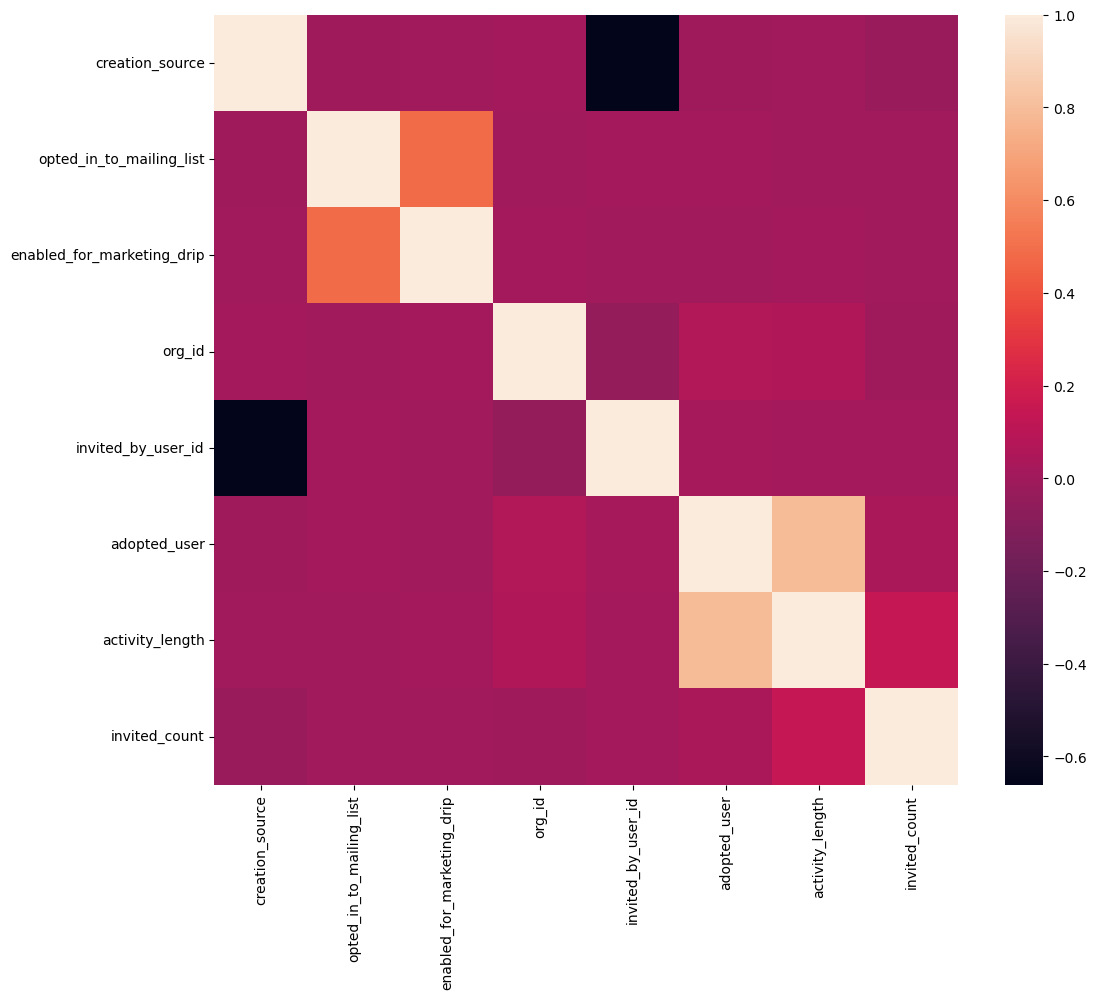

In [209]:
plt.subplots(figsize=(12,10))
sns.heatmap(df.corr());

Seems like the created features are correlated to the target.

In [210]:
from sklearn.metrics import classification_report, confusion_matrix

#print out classification report and confusion matrix
y_pred = rf.predict(y_train)

print(classification_report(y_test, y_pred))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3414
           1       0.90      0.87      0.88       546

    accuracy                           0.97      3960
   macro avg       0.94      0.93      0.93      3960
weighted avg       0.97      0.97      0.97      3960

confusion matrix:
[[3359   55]
 [  73  473]]


Still loooks great. We could probably improve slightly with a parameter grid.

Let's see which features are the most important.

In [211]:
#make a df that displays the cofficients indexed by feature name
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(X.columns)
feature_importance.coef.nlargest(10)

activity_length               0.894413
org_id                        0.052570
invited_by_user_id            0.025105
creation_source               0.011717
invited_count                 0.009815
opted_in_to_mailing_list      0.003521
enabled_for_marketing_drip    0.002858
Name: coef, dtype: float64

In [212]:
#define func to find ecdf of dataset
def ecdf(array):
    """Compute Estimated CDF for a one-dimensional array."""
    n = len(array)
    x = np.sort(array)
    y = np.arange(1, n+1) / n
    return x, y

Plot the Estimated CDF for `adopted` and `Non-adopted` 

In [213]:
adopted = df.activity_length.loc[df['adopted_user'] == 1]
not_adopted = df.activity_length.loc[df['adopted_user'] == 0]

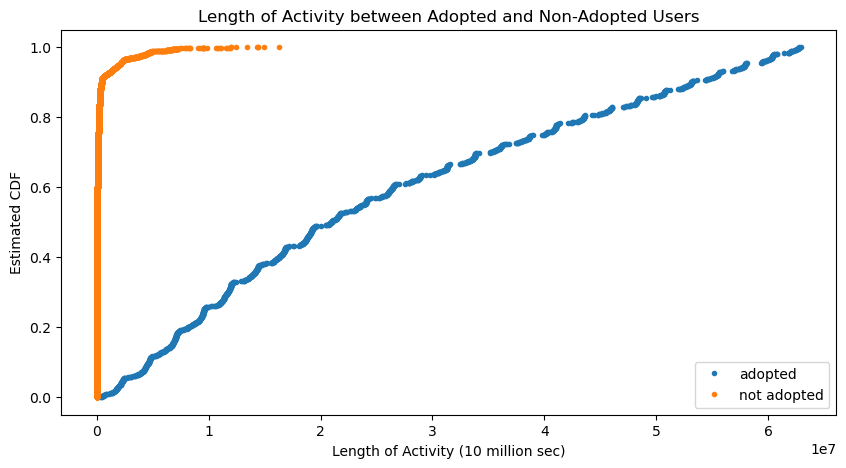

In [214]:
#set fig size
%matplotlib inline
plt.figure(figsize=(10,5))

x_active, y_active = ecdf(adopted)
x_inactive, y_inactive = ecdf(not_adopted)

plt.plot(x_active, y_active, marker='.', linestyle='none')
plt.plot(x_inactive, y_inactive, marker='.', linestyle='none')
plt.title('Length of Activity between Adopted and Non-Adopted Users')
plt.xlabel('Length of Activity (10 million sec)')
plt.ylabel('Estimated CDF')
plt.legend(['adopted', 'not adopted'])
plt.show()

Clearly, activity length is a great indicator as the activity of non-adopted users drops of quickly and it appears the maximum of non-adopted users is right around the median of the adopted users.



In [215]:
adopted = df.invited_count.loc[df['adopted_user'] == 1]
not_adopted = df.invited_count.loc[df['adopted_user'] == 0]

In [216]:
print("Percent of adoption among those who invited someone: " , df[df['invited_count'] > 0].adopted_user.mean())
print("Percent of adoption among those who did not invited someone: " , df[df['invited_count'] == 0].adopted_user.mean())

Percent of adoption among those who invited someone:  0.17121684867394696
Percent of adoption among those who did not invited someone:  0.12897414158541756


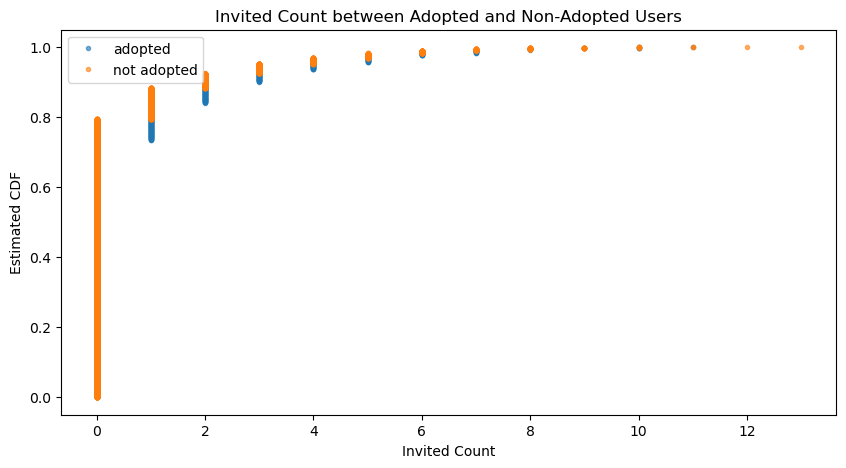

In [217]:
plt.figure(figsize=(10,5))

x_active, y_active = ecdf(adopted)
x_inactive, y_inactive = ecdf(not_adopted)

plt.plot(x_active, y_active, marker='.', linestyle='none', alpha=.6)
plt.plot(x_inactive, y_inactive, marker='.', linestyle='none',alpha=.6)
plt.title('Invited Count between Adopted and Non-Adopted Users')
plt.xlabel('Invited Count')
plt.ylabel('Estimated CDF')
plt.legend(['adopted', 'not adopted'])
plt.show()

Overall there are several interesting points to consider. First user logins have a steady upward trend which clearly is a good thing. Are they increasing as quickly as desired is not known. The available data on the logins does not seem to show a particular day of the week or time of day having any periodic cycle. This may be due to the lack of information on the timezone of the user and only having logins based on what seems to be the global time.

Of the 12000 users, just under 75% logged in after creating their account. Finding some way to get the 25+% that didn't log in at all to become more active could increase the adopted users. Similarly, encouraging users who have logged in to login again would probably be the best way to increase adoption. As second potential method to increase adoption would be to encourage users to invite others since those who did invite someone else to the platform were more likely to be adopted users.
